# 02_behavior_analysis — Исследование поведения пациентов
**Цель:** проверить гипотезы, сформулированные в EDA, и найти инсайты пациентского поведения

# Импорт библиотек

In [1]:
import pandas as pd
import numpy as np

from scipy.stats import chi2_contingency
from scipy.stats import beta

import re

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, Normalize
from matplotlib.cm import get_cmap
import seaborn as sns

from IPython.display import display, HTML

# Загрузка данных

In [2]:
visits = pd.read_csv('data/processed/visits_prepared.csv')
channels = pd.read_csv('data/processed/channels_prepared.csv')

In [3]:
# Присвоение типа datetime64[ns] столбцам, потерявшим корректный dtype при импорте
visits[['pay_datetime', 'date']] = visits[['pay_datetime', 'date']].apply(pd.to_datetime)
channels['visit_date'] = pd.to_datetime(channels['visit_date'])

In [4]:
print('Таблица visits')
display(visits.head(3))

Таблица visits


,pay_datetime,date,check_id,admin_id,pat_id,doc_id,service_code,service_name,price_rub,qty,discount_rub,bonus_rub,amount_rub,payment_method,cashflow_type,op_type,referrer_id,month
0,2025-09-29 20:23:00,2025-09-29,1749,A004,P000506,D014,A12.10.001,Электрокардиография с физической нагрузкой,800,1,0,0,800,Картой,Приход,Полный расчет,R0001,2025-09
1,2025-09-29 18:57:00,2025-09-29,1748,A004,P000560,D003,B01.047.001,Справка для занятий спортом,2300,1,0,0,2300,Картой,Приход,Полный расчет,R0001,2025-09
2,2025-09-29 18:56:00,2025-09-29,1747,A004,P000183,D003,B01.047.001,Справка для занятий спортом,2300,1,0,0,2300,Картой,Приход,Полный расчет,R0001,2025-09


In [5]:
print('Таблица channels')
display(channels.head(3))

Таблица channels


,visit_date,first_visit_date,first_channel_date,channel,pat_id,doc_id,admin_id,services_sum_rub,month,days_since_last,visit_cat
0,2025-02-17,2025-02-17,2025-02-17,Не указан,P000001,D002,A004,2000,2025-02,NaN,Первичный
1,2025-09-17,2025-09-17,2025-09-17,ПроДокторов,P000002,D008,Продокторов,2000,2025-09,NaN,Первичный
2,2025-02-19,2025-02-19,2025-02-19,МедТочка,P000003,D008,Онлайн-запись,2000,2025-02,NaN,Первичный


# Общий анализ поведения

*Для проведения анализа поведения пациентов необходимо классифицировать посещения по категориям получаемых услуг*

В основу категорий ляжет причина получения пациентом услуги:
- Получение справки
- Посещение врача и связанные с ним процедуры
- Сдача анализов без назначения специалистами клиники
- Посещение диагностических процедур без назначения специалистами клиники
- Посещение лечебных процедур без назначения специлистами клиники

Подобная структуризация посещений позволит определить наиболее привлекательные направления, чтобы акцентировать внимание потенциальных клиентов на том, что им вероятнее всего будет необходимо.

Признаки, которые будут добавлены в данные:
1. **service_category**: категория самой услуги (определяет обобщенный тип услуги)
2. **visit_category**: категория визита (для устранения композиционного смещения, когда пациент оплачивал, например, анализы в рамках посещения врача); Этот признак позволит определить, какие направления деятельности приносят наибольшую выручку, стимулируя траты в других катгориях услуг;

3. **specified_service_category**: уточненная категория услуги (для определения типа услуги внутри обобщенной категории);
4. **specified_visit_category**: уточненная категория визита (для определения типа визита внутри обобщенной категории).

In [6]:
# === Подготовка данных === #

# Фильтрация и присвоение категорий процедурам по названию

# СПРАВКИ
mask = visits['service_name'].str.contains(r'Справк', flags=re.IGNORECASE, regex=True)
visits.loc[mask, 'service_category'] = 'Справки'

# АНАЛИЗЫ
mask = visits['service_code'].str.contains(
    r'^\d{1,3}\.\d{1,3}\.[A-Za-zА-Яа-я]\d{1,3}(?:\.\d{1,3})?$',
    regex=True,
    na=False
)
visits.loc[mask, 'service_category'] = 'Анализы'

# ДИАГНОСТИЧЕСКИЕ
must_contain = [
    r'узи',
    r'\b\w*\s?\w*графия\b',
    r'дуоденально',
    r'крови',
    r'скопия',
    r'пределение',
    r'сканирование',
    r'исследование',
    r'ревизия'
]
mask = visits['service_name'].str.contains(
    '|'.join(must_contain),
    flags=re.IGNORECASE,
    regex=True,
    na=False
)
visits.loc[mask, 'service_category'] = 'Диагностические'

# ПРИЕМЫ ВРАЧЕЙ
mask = visits['service_name'].str.contains(r'(?:[Пп]ри[её]м)|(?:[Вв]рач)|(?:онсультация)|(?:особие)', regex=True)
visits.loc[mask, 'service_category'] = 'Приемы врачей'

# ЛЕЧЕБНЫЕ (оставшиеся) + перекатегоризация для "Дуоденальное зондирование (лечебное)""
mask1 = (
    ~visits['service_category'].str.contains(r'\w+', na=False)
)
mask2 = (
    visits['service_name'].str.contains('лечебное')
)
mask = mask1 | mask2
visits.loc[mask, 'service_category'] = 'Лечебные'


# === Исправление неверно присовенной категории анализам === #
mask = visits['service_name'].str.contains(r'анализ крови', na=False)
visits.loc[mask, 'service_category'] = 'Анализы'


In [7]:
visits[visits['service_name'].str.contains('оденальное')].groupby(['service_name', 'service_category'])['service_category'].count()

service_name                               service_category
Дуоденальное зондирование диагностическое  Диагностические     68
Дуоденальное зондирование лечебное         Лечебные            47
Name: service_category, dtype: int64

Добавим категоризацию врачебных приемов, лечебных и диагностических процедур для дальнейшего анализа.

In [8]:
# === Категоризация диагностических процедур === #
# Присваивание категории УЗИ
mask = visits['service_name'].str.contains('УЗИ|льтразвук|доплерогр|сканирование')
visits.loc[mask, 'specified_service_category'] = 'УЗИ'

# ЭКГ
mask = visits['service_name'].str.contains('лектрокардиография')
visits.loc[mask, 'specified_service_category'] = 'ЭКГ'

# Диагностика легких
mask = visits['service_name'].str.contains('Диагностика легких|оксида азота|Спирография')
visits.loc[mask, 'specified_service_category'] = 'Диагностика легких'

# Гинекология
mask = visits['service_name'].str.contains('Микроскопическое|Кольпоскопия|Цитологическое')
visits.loc[mask, 'specified_service_category'] = 'Гинекология'

# Анализ крови
mask = visits['service_name'].str.contains('крови|ммунный|тестостерон|Холестерин')
visits.loc[mask, 'specified_service_category'] = 'Анализ крови'

# Анализ желчи
mask = visits['service_name'].str.contains(r'(Посев желчи)|(зондирование диагно)')
visits.loc[mask, 'specified_service_category'] = 'Дуоденальное зондирование'


# === Категоризация врачебных приемов === #
# Дерматовенеролог
mask = visits['service_name'].str.contains('дерматовенеролог')
visits.loc[mask, 'specified_service_category'] = 'Дерматовенеролог'

# Терапевт
mask = visits['service_name'].str.contains('Терапевт|терапевт')
visits.loc[mask, 'specified_service_category'] = 'Терапевт'

# Пульмонолог
mask = visits['service_name'].str.contains('пульм[оа]нолог')
visits.loc[mask, 'specified_service_category'] = 'Пульмонолог'

# Подиатр
mask = visits['service_name'].str.contains('подиатр')
visits.loc[mask, 'specified_service_category'] = 'Подиатр'

# Оториноларинголог
mask = visits['service_name'].str.contains('оториноларинголог')
visits.loc[mask, 'specified_service_category'] = 'Оториноларинголог'

# Невролог
mask = visits['service_name'].str.contains('невролог')
visits.loc[mask, 'specified_service_category'] = 'Невролог'

# Акушер-гинеколог
mask = visits['service_name'].str.contains('акушер')
visits.loc[mask, 'specified_service_category'] = 'Акушер-гинеколог'

# Подиатр
mask = visits['service_name'].str.contains('подиатр')
visits.loc[mask, 'specified_service_category'] = 'Подиатр'

# Эндокринолог
mask = visits['service_name'].str.contains('эндокринолог')
visits.loc[mask, 'specified_service_category'] = 'Эндокринолог'

# Онколог-маммолог
mask = visits['service_name'].str.contains('онколог')
visits.loc[mask, 'specified_service_category'] = 'Онколог-маммолог'


# === Категоризация лечебных процедур === #
# Массаж
mask = visits['service_name'].str.contains('[Мм]ассаж')
visits.loc[mask, 'specified_service_category'] = 'Массаж'

# Чек-апы
mask = visits['service_name'].str.contains('Чек-ап')
visits.loc[mask, 'specified_service_category'] = 'Чекапы'

# Детокс
mask = visits['service_name'].str.contains('Детокс')
visits.loc[mask, 'specified_service_category'] = 'Детокс'

# Уколы и капельницы
mask = visits['service_name'].str.contains('[Вв]нутри|Лабораторный|Инъекция|Пентоксифиллин|Актовегин')
visits.loc[mask, 'specified_service_category'] = 'Уколы и капельницы'

# Дуоденальное зондирование
mask = visits['service_name'].str.contains('Дуоденальное зондирование лечебное')
visits.loc[mask, 'specified_service_category'] = 'Дуоденальное зондирование'

# Иглорефлексотерапия 
mask = visits['service_name'].str.contains('Иглорефлексотерапия')
visits.loc[mask, 'specified_service_category'] = 'Иглорефлексотерапия'

# Снятие швов
mask = visits['service_name'].str.contains('Снятие швов')
visits.loc[mask, 'specified_service_category'] = 'Снятие швов'


# === Исправление категорий === #
# Оториноларинголог
mask = visits['service_name'].str.contains('Промывание ушей')
visits.loc[mask, 'service_category'] = 'Приемы врачей'
visits.loc[mask, 'specified_service_category'] = 'Оториноларинголог'

# Акушер-гинеколог
mask = visits['service_name'].str.contains('прерывание|Вскрытие фурункула')
visits.loc[mask, 'service_category'] = 'Приемы врачей'
visits.loc[mask, 'specified_service_category'] = 'Акушер-гинеколог'

# Дерматовенеролог
mask = visits['service_name'].str.contains('кондилом')
visits.loc[mask, 'service_category'] = 'Приемы врачей'
visits.loc[mask, 'specified_service_category'] = 'Дерматовенеролог'

C:\Users\pavsabiroff\AppData\Local\Temp\ipykernel_2936\1693312960.py:23: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mask = visits['service_name'].str.contains(r'(Посев желчи)|(зондирование диагно)')


In [9]:
# Первичное распределение категорий услуг
visits['service_category'].value_counts()

service_category
Приемы врачей      610
Диагностические    491
Анализы            362
Лечебные           293
Справки            103
Name: count, dtype: int64

Для минимизации ошибки ***композиционного смещения*** введем категоризацию визитов, для этого нужно изменить категории анализов и диагностических процедур на "Прием врача", если чек по ним сопровождался приемом, так как фактически пациент прошел эти процедуры в рамках посещения специалиста.

В остальных случаях категории менять не стоит, так как скорее всего посещение клиники было связано с ее возможностями провести необходимую процедуру.

То есть анализы и диагностика, проведенные **без приема врача** внутри одного чека, вероятнее всего были фактором привлечения пациента в клинику.

В то время как чеки, **содержащие прием врача**, вероятнее всего говорят о том, что именно наличие специалиста привлекло пациента в клинику.

Для начала найдем все записи, когда человек посещал врача:

In [10]:
def has_doctor(group):
    return group.str.contains('Приемы врачей').any()

visits['has_doctor_today'] = visits.groupby(['date', 'pat_id'])['service_category'].transform(lambda x: has_doctor(x))

Ручная проверка оказанных услуг в день приема врача позволяет сказать, что анализы и диагностика, назначенные вне даты приема, но сданные в этот день, либо отсуствуют, либо незначительны по своему количеству (посещения определенного врача полностью соотвествуют сданным далее процедурам).
 * Текущая структура данных не позволяет в полной мере оценить причины, по которым пациент приобрел конкретную услугу, поэтому ручная проверка быстрее и точнее автоматизированной.

Для дальнейшего анализа будем считать, что дополнительные услуги в день посещения врача связаны непосредственно с приемом врача.

Поэтому стоит классифицировать подобные визиты как "Приемы врачей", чтобы более точно понять драйверы роста клиники.

In [11]:
# Присвоение категории "Приемы врачей" связанным с ними посещениям
mask = visits['has_doctor_today'] == True
visits.loc[mask, 'visit_category'] = 'Приемы врачей'

Важно заметить, что целью посещения клиники может быть получение справки. Ее получение сопровождается и посещением врача, и проведением диагностических процедур, и сдачей анализов.

Проверим, как клиника проводит оплату по данному направлению деятельности, и отнесем визиты в день получения справки к ее категории.

In [12]:
def certificate_obtaining(group):
    return group.str.contains('Справки').any()

visits['certificate_obtaining'] = visits.groupby(['date', 'pat_id'])['service_category'].transform(lambda x: certificate_obtaining(x))

# Фильтрация для получения позиций чеков со справками
mask = visits['certificate_obtaining'] == True

print('Услуги в день получения пациентом справки'.upper())
visits.loc[mask, 'service_name'].value_counts().reset_index(name='services_cnt')

УСЛУГИ В ДЕНЬ ПОЛУЧЕНИЯ ПАЦИЕНТОМ СПРАВКИ


,service_name,services_cnt
0,Справка для занятий спортом,103
1,Ферритин,1
2,Забор крови,1
3,Железо,1
4,Клинический анализ крови с лейкоцитарной форму...,1


In [13]:
# Присвоение процедурам, связанным с получением справки, категории "Справки"
visits.loc[visits['certificate_obtaining'] == True, 'visit_category'] = 'Справки'

Также может иметь место ситуация, когда сдача анализов или проведение процедур происходили в день, когда не было приема врача (первичный прием, проведение назначенных процедур и повторный прием происходили в разные дни). Будем считать, что если пациент явился на данные процедуры в течение 21 дня после посещения врача, будем относить это к результатам врачебных назначений.

Необходимо проверить появление такого паттерна.

In [14]:
# выбор признаков, чтобы не перегружать вывод при join
cols = ['date', 'check_id', 'pat_id', 
        'service_name', 'service_category', 'specified_service_category',
        'visit_category', 
        'has_doctor_today', 'certificate_obtaining']

# временная таблица
tmp_table = visits.loc[:, cols].copy()
tmp_table = tmp_table.query(
    "certificate_obtaining == False"
)

# self-merge для сопоставления действий
tmp_table = tmp_table.merge(
    tmp_table,
    on='pat_id',
    suffixes=['_past', "_next"]
).query(
    "date_past < date_next"                                             # чеки в разные дни
).query(
    "(date_next - date_past).dt.days <= 21"                             # не более 21 дня между посещениями
).query(
    "service_category_past == 'Приемы врачей'"                          # сначала прием врача
).query(
    "service_category_next.isin(['Анализы', 'Диагностические', 'Лечебные'])"        # потом процедура без приема врача
).query(
    "has_doctor_today_next == False"                                    # обусловлено визитом к врачу именно в прошлую дату
).query(
    "~service_name_next.str.contains('[Мм]ассаж')"                       # исключаем массаж, так как его не назначают в клинике
)

# Список специальностей
doc_spec = [
    'Дерматовенеролог', 
    'Терапевт',
    'Пульмонолог',
    'Подиатр',
    'Оториноларинголог',
    'Невролог',
    'Акушер-гинеколог',
    'Подиатр',
    'Эндокринолог',
    'Онколог-маммолог'
]

# Фильтр по предшествующему посещению врача
rows_with_doc_prev_visit = (
    tmp_table['specified_service_category_past'].isin(doc_spec)      # Первая запись к какому-то из врачей
)

# Распределение чеков по количеству посещенных разных врачей до проведения назначенных процедур
print(
    'Распределение чеков по количеству посещенных разных врачей до проведения назначенных процедур:\n',
    tmp_table.loc[rows_with_doc_prev_visit].groupby(['check_id_next'])['specified_service_category_past'].nunique().value_counts()
)

Распределение чеков по количеству посещенных разных врачей до проведения назначенных процедур:
 specified_service_category_past
1    31
2     3
Name: count, dtype: int64


В 3 чеках присуствует посещение двух врачей (проверим позже на всех данных).

______
Теперь можно получить информацию по всем чекам, которые:
1. Содержат проведение процедур в рамках посещения врача;
2. Мотивированы к сдаче врачом, но сданы в другой день (не позднее 21 дня со дня приема)

Категории визитов по этим чекам можно категоризовать как "Приемы врачей". Так станет понятно, какую выручку на самом деле обеспечивают непосредственно врачи, стимулируя оплачивать дополнительные услуги.

In [15]:
# Информация по номеру чека и специальности посещенного врача c разрыв в дате
# Мотивация к посещению - местное назначение врача
influenced_gapped_checks = tmp_table[['check_id_next', 'specified_service_category_past']].drop_duplicates()
influenced_gapped_checks = influenced_gapped_checks.rename(
    columns={
        'check_id_next': 'check_id', 
        'specified_service_category_past':'specified_service_category'
    }
)
# Информация по номеру чека и специальности посещенного врача
# В день посещения врача
influenced_moment_checks = visits.query(
    "visit_category == 'Приемы врачей'"
).query(
    "specified_service_category.isin(@doc_spec)"
)[['check_id', 'specified_service_category']].drop_duplicates()


# Все чеки с назначениями
influenced_checks = (
    pd.concat(
        [influenced_gapped_checks, influenced_moment_checks],
        axis=0,
        ignore_index=True
    )
)

# Проверим чеки с несколькими врачами
influenced_checks['check_id'].value_counts().iloc[:6]

check_id
330     2
320     2
311     2
434     2
303     2
1107    1
Name: count, dtype: int64

In [16]:
# Количество посещений с несколькими врачами и последующими процедурами
visits.loc[
    visits['check_id'].isin([311, 330, 320, 434, 303]),
    ['date', 'check_id', 'pat_id', 'service_name', 'specified_service_category', 'amount_rub']
]

,date,check_id,pat_id,service_name,specified_service_category,amount_rub
1543,2025-04-25,434,P000813,"Первичный прием врача-невролога, рефлексотерап...",Невролог,2000
1544,2025-04-25,434,P000813,Первичный прием врача-пульмонолога,Пульмонолог,2000
1627,2025-04-08,330,P000127,Внутривенное капельное введение лекарственных ...,Уколы и капельницы,630
1635,2025-04-07,320,P000127,Внутривенное капельное введение лекарственных ...,Уколы и капельницы,630
1643,2025-04-04,311,P000127,Внутривенное капельное введение лекарственных ...,Уколы и капельницы,630
1650,2025-04-03,303,P000127,"Первичный прием врача-невролога, рефлексотерап...",Невролог,1800
1651,2025-04-03,303,P000127,Первичный прием врача-терапевта,Терапевт,1800
1652,2025-04-03,303,P000127,Внутривенное капельное введение лекарственных ...,Уколы и капельницы,630
1653,2025-04-03,303,P000127,Забор крови,Анализ крови,3047


Количество посещений с несколькими врачами и последующими процедурами мало. Не произойдет значимого смещения выводов при ошибке определения категории визита.

In [17]:
# === Заполнение пустых specified_service_category === #
# (не назначена подробная категоризация, дублируем общую)
mask = visits['specified_service_category'].isna()
visits.loc[mask, 'specified_service_category'] = visits.loc[mask, 'service_category']


# === Заполнение visit_category === #
# Назначения, выполненные в отличный от приема день
mask = visits['check_id'].isin(influenced_checks['check_id'])
visits.loc[mask, 'visit_category'] = 'Приемы врачей'

# Остается диагностические, лечебные и анализы
visits.loc[visits['visit_category'].isna(), 'visit_category'] = visits.loc[visits['visit_category'].isna(), 'service_category']

# === Заполнение specified_visit_category === #
# Временный столбец с категориями из стимулированных врачами чеков
visits = (visits
    .merge(
        influenced_checks[['check_id', 'specified_service_category']],
        on='check_id',
        how='left',
        suffixes=['', '_temp']
    )
)
# По ID чеков ищем Дата-Пациент, чтобы привязать выручку к врачу,
# если пациент оплатил все в рамках одного визита разными чеками
doctor_visited_today = visits.loc[
    visits['specified_service_category_temp'].notna(),
    ['date', 'pat_id', 'specified_service_category_temp']
].drop_duplicates().rename(columns={"specified_service_category_temp": 'doctor_visited_today'})

# Временный столбец
visits = visits.merge(
    doctor_visited_today[['date', 'pat_id', 'doctor_visited_today']],
    on=['date', 'pat_id'],
    how='left'
)
# Перенос значений в первый временный столбец, чтобы не плодить лишние данные
mask = visits['doctor_visited_today'].notna()
visits.loc[mask, 'specified_service_category_temp'] = visits.loc[mask, 'doctor_visited_today']
# Удаление лишнего столбца
visits.drop('doctor_visited_today', axis=1, inplace=True)

# Финальный столбец подробных категорий визитов
visits['specified_visit_category'] = np.nan
# Указанные врачи для всех influenced_checks
mask = ~visits['specified_service_category_temp'].isna()       # Указанные врачи для чеков целиком
visits.loc[mask, 'specified_visit_category'] = visits.loc[mask, 'specified_service_category_temp']
# Оставшиеся категории визитов равны категории получаемой услуги
mask = visits['specified_visit_category'].isna()
visits.loc[mask, 'specified_visit_category'] = visits.loc[mask, 'specified_service_category']
# Присвоение визитам, связанным с получением справки, категории "Справки"
visits.loc[visits['certificate_obtaining'] == True, 'specified_service_category'] = 'Справки'
visits.loc[visits['certificate_obtaining'] == True, 'specified_visit_category'] = 'Справки'

# Исправление категории, ошибочно назначенной по пересекающейся маске в категории анализов
mask = visits['service_name'].str.contains('оспитальн') & ~visits['visit_category'].eq('Приемы врачей')
visits.loc[mask, 'specified_visit_category'] = 'Анализы'
visits.loc[mask, 'specified_service_category'] = 'Анализы'
visits.loc[mask, 'specified_visit_category'] = 'Анализы'

# Исправление категории, ошибчно назначенной по пересекающейся маске в категории диагностики
mask = visits['visit_category'].eq('Анализы') & visits['specified_visit_category'].str.contains('Анализ крови')
visits.loc[mask, 'service_category'] = 'Анализы'
visits.loc[mask, 'specified_service_category'] = 'Анализы'
visits.loc[mask, 'specified_visit_category'] = 'Анализы'

# Присвоение верной категории визита к подиатру
mask = visits['service_name'].str.contains('Плантография|Пособие|подбору')
visits.loc[mask, 'specified_visit_category'] = 'Подиатр'

#  Исправление категории, ошибочно назначенной по пересекающейся маске в категории лечебных
mask = visits['service_name'].str.contains('чистка лица')
visits.loc[mask, 'service_category'] = 'Лечебные'
visits.loc[mask, 'specified_service_category'] = 'Косметология'
visits.loc[mask, 'specified_visit_category'] = 'Косметология'

# Удаление временного столбца
visits.drop('specified_service_category_temp', axis=1, inplace=True)

C:\Users\pavsabiroff\AppData\Local\Temp\ipykernel_2936\1443351301.py:48: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '['Дерматовенеролог' 'Терапевт' 'Терапевт' ... 'Невролог' 'Пульмонолог'
 'Невролог']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  visits.loc[mask, 'specified_visit_category'] = visits.loc[mask, 'specified_service_category_temp']


In [18]:
# Проверка корректности распределения категорий
visits.groupby(['visit_category', 'specified_visit_category'])['specified_visit_category'].size()

visit_category   specified_visit_category 
Анализы          Анализы                      166
Диагностические  Анализ крови                  39
                 Гинекология                    5
                 Диагностика легких            23
                 Дуоденальное зондирование     70
                 УЗИ                          174
                 ЭКГ                           22
Лечебные         Детокс                         5
                 Дуоденальное зондирование     47
                 Иглорефлексотерапия            9
                 Косметология                   1
                 Массаж                        60
                 Уколы и капельницы           135
                 Чекапы                         3
Приемы врачей    Акушер-гинеколог             111
                 Дерматовенеролог              64
                 Невролог                     108
                 Онколог-маммолог              24
                 Оториноларинголог             19
       

________
После категоризации можно изучить структуру среднего чека с устраненным композиционным смещением.

# Проверка гипотез

## H1 & H5: Сезонный рост пациентов & Анализ структуры среднего чека

**Контекст**

На этапе анализа данных предполагалось:

(H1) — рост числа пациентов в августе–сентябре может быть связан с сезонными факторами (начало учебного года, профилактические осмотры и т. п.);

(H5) — увеличение удельного веса анализов в структуре чеков могло привести к росту медианного чека в сентябре.

Обе гипотезы были включены в план для проверки влияния структуры спроса на показатели чеков.

В сентябре 2025 года официальные источники информации заявляли о серьезном росте заболеваемости вирусными инфекциями. В силу отсуствия официальных данных на момент исследования, проверить фактор сезонности объективно нельзя (экстраполяция по предыдущим годам даст смещение).

Для решения этой проблемы можно проверить прирост обращений по названием услуг и с помощью метода экспертных оценок сделать вывод о влиянии роста ОРВИ на рост пацеинтов в клинике.

Также стоит проверить - не уменьшилось ли количество обращений в клинику по услугам, не связанным с сезонными факторами.

C:\Users\pavsabiroff\AppData\Local\Temp\ipykernel_2936\2752710233.py:34: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  df_all.pivot_table(index='month', columns='category', values='avg_rub', aggfunc='mean')


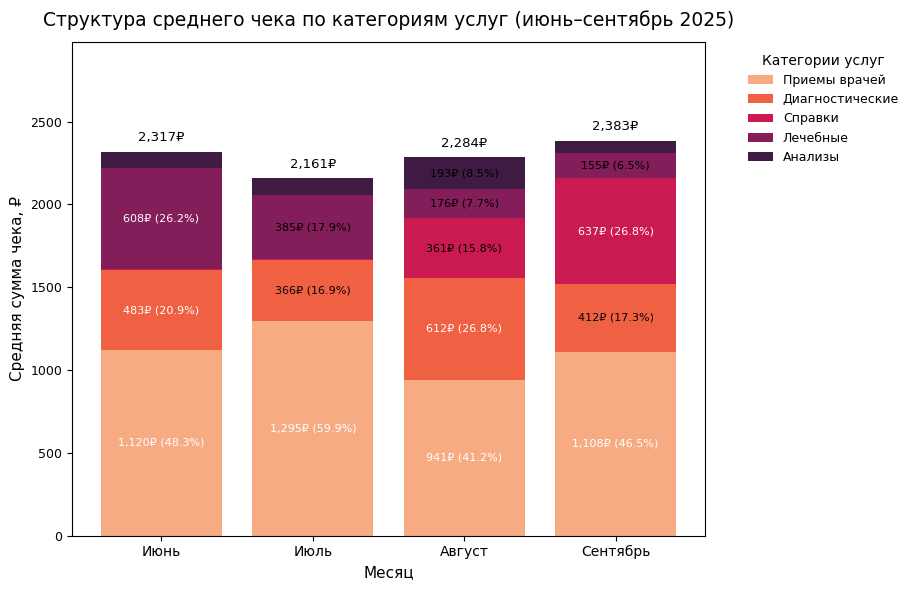

In [19]:
# === Настройки === #
months_map = {
    '2025-06': 'Июнь',
    '2025-07': 'Июль',
    '2025-08': 'Август',
    '2025-09': 'Сентябрь'
}
months = list(months_map.keys())

ordered_cats = ['Приемы врачей', 'Диагностические', 'Справки', 'Лечебные', 'Анализы']

def get_services_structure(visits, month):
    df = visits.query('month == @month')

    # Распределение по суммам в чеке
    services_distribution_rub = (
        df.groupby(['check_id', 'visit_category'])['amount_rub']
        .sum()
        .unstack(fill_value=0)
    )

    avg_per_cat = services_distribution_rub.mean().rename('avg_rub').reset_index()
    avg_per_cat.columns = ['category', 'avg_rub']
    avg_per_cat['month'] = months_map[month]
    return avg_per_cat

# === Объединяем все месяцы === #
df_all = pd.concat([get_services_structure(visits, m) for m in months], ignore_index=True)

df_all['category'] = pd.Categorical(df_all['category'], categories=ordered_cats, ordered=True)
df_all = df_all.groupby(['month', 'category'], as_index=False, observed=False)['avg_rub'].mean()

pivot_df = (
    df_all.pivot_table(index='month', columns='category', values='avg_rub', aggfunc='mean')
    .fillna(0)
    .reindex([months_map[m] for m in months])
)[ordered_cats]

palette = sns.color_palette('rocket_r', n_colors=len(ordered_cats))
color_map = dict(zip(ordered_cats, palette))

# === Построение графика === #
fig, ax = plt.subplots(figsize=(11, 6))
bottom = np.zeros(len(pivot_df))

for cat in ordered_cats:
    values = pivot_df[cat].values
    ax.bar(pivot_df.index, values, bottom=bottom, color=color_map[cat], label=cat)

    # Подписи в сегментах
    for i, month in enumerate(pivot_df.index):
        if values[i] > 0:
            total = pivot_df.loc[month].sum()
            share = values[i] / total
            y_pos = bottom[i] + values[i] / 2

            # пропускаем подпись, если сегмент слишком мал
            if share < 0.05:
                continue

            ax.text(
                month,
                y_pos,
                f"{int(values[i]):,}₽ ({share*100:.1f}%)",
                ha='center',
                va='center',
                fontsize=8,
                color='white' if share > 0.18 else 'black',
                fontweight='book'
            )

    bottom += values

# Итоговые суммы над столбцами
for i, month in enumerate(pivot_df.index):
    total = pivot_df.loc[month].sum()
    ax.text(
        month,
        total + total * 0.02,
        f"{int(total):,}₽",
        ha='center',
        va='bottom',
        fontsize=9.5,
        fontweight='light'
    )

# === Оформление === #
ax.set_title('Структура среднего чека по категориям услуг (июнь–сентябрь 2025)', fontsize=13.5, pad=12)
ax.set_ylabel('Средняя сумма чека, ₽', fontsize=11)
ax.set_xlabel('Месяц', fontsize=11)
ax.set_ylim(0, pivot_df.sum(axis=1).max() * 1.25)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=9)

# Легенда
ax.legend(
    title='Категории услуг',
    bbox_to_anchor=(1.05, 1),
    loc='upper left',
    fontsize=9,
    title_fontsize=10,
    frameon=False
)

plt.savefig(
    "reports/visualisation/fig08_avg_check_service_category_structure.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.show()

Проверим динамику визитов по категориям услуг.

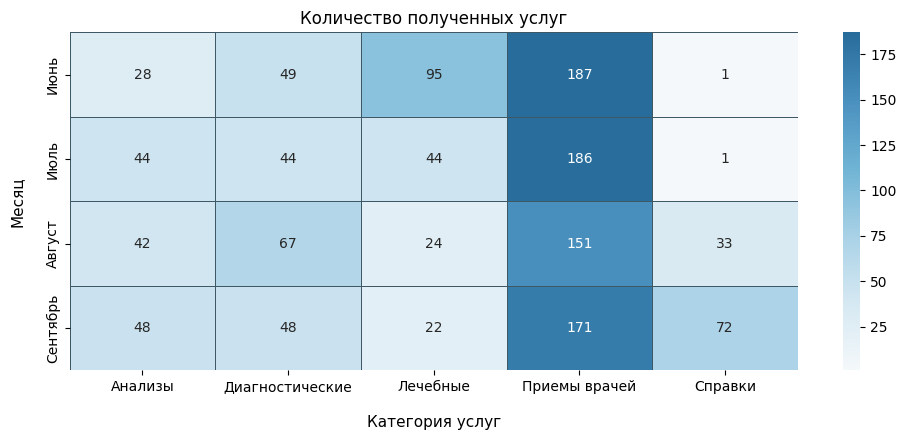

In [20]:
months = ['2025-06', '2025-07', '2025-08', '2025-09']

# Динамика визитов по категориям услуг
visits_by_category = (
    visits
    .query("month in @months")                                          # фильтрация по месяцам
    .groupby(['month', 'visit_category'])['visit_category']             # Группировка по месяцу и услуге
    .count()                                                            # Подсчет количества категорий услуг в каждый месяц
    .unstack(fill_value=0)                                              # Long -> wide
)

modern_turquoise_soft = LinearSegmentedColormap.from_list(
    "modern_turquoise_soft",
    [
        "#F4F8FA",  # нейтральный, ближе к серо-бирюзовому (фон)
        "#D5E8F2",  # лёгкая бирюзовая дымка
        "#A8D1E6",  # мягкий голубовато-бирюзовый
        "#6FB3D4",  # средний, комфортный оттенок
        "#4A90BF",  # уверенный, но не “кричащий”
        "#276C9B"   # тёмный акцент без потери контраста
    ]
)

fig = plt.figure(figsize=(10, 4.5))
ax = fig.add_subplot()

sns.heatmap(
    visits_by_category,
    annot=True,
    fmt=".0f",
    cmap=modern_turquoise_soft,
    linewidths=0.5,
    linecolor="#3e5865"
)

ax.set_yticklabels(['Июнь', 'Июль', 'Август', 'Сентябрь'])
ax.set_title('Количество полученных услуг')

ax.set_ylabel('Месяц', fontsize=11, labelpad=15)
ax.set_xlabel('Категория услуг', fontsize=11, labelpad=15)

plt.tight_layout()

plt.savefig(
    "reports/visualisation/fig09_service_category_monthly_count_heatmap.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

*Важно: категоризация услуг внутри одного чека (против категоризации чеков как результатов визита) приведет к появлению нескольких категорий в одном чеке и определит один визит несколько раз в разные категории.*

Это означает, что данные покажут востребованность категорий услуг. При этом непосредственно выводы о визитах по категориям услуг будут смещены.

С июля по август произошел рост числа обращений в категории диагностических процедур (с 44 до 67). Затем этот показатель достиг минимума.

После июня произошло существенное падение в спросе на лечебные процедуры (со 95 до 44 в июне). После этого спрос неуклонно снижался вплоть до 22 в августе.

Количество обращений к врачам находилось примерно на одном уровне, кроме августа, когда было время отпусков.
______
С учетом того, 60-70% от стоимости среднего чека регулярно складывается из приема врачей и из диагностических процедур, следует проверить динамику спроса на услуги внутри этих категорий.

Также нужно проверить, чем вызван снижение количества лечебных процедур после июля: изменением структуры записи или иными факторами.

In [21]:
# Функция для получения данных по выбранной общей категории визита
def get_data_by_service_category(df, category):
    df_result = df.loc[
        df['visit_category'].eq(category),
        ['date', 'month', 'check_id', 'service_code',
         'service_name', 'doc_id', 'amount_rub',
         'service_category', 'visit_category', 'specified_visit_category'
        ]
    ].copy()
    return df_result

# Функция для получения сводной таблицы внутри представленной категории
def get_pivot_table(df, aggfunc):
    df_pivot = (
        df.groupby(['specified_visit_category', 'month'])['amount_rub']
        .agg(aggfunc)
    ).unstack(fill_value=0).copy()

    df_pivot['Итого'] = df_pivot.sum(axis=1)

    return df_pivot.sort_values('Итого', ascending=False)

In [22]:
#  Количество врачебных приемов
category_diagnostic_data = get_data_by_service_category(visits, 'Приемы врачей')
category_diagnostic_pivot = get_pivot_table(category_diagnostic_data, 'count')
category_diagnostic_pivot.index.name = 'Направление приема'
category_diagnostic_pivot.columns.name = 'Месяц'
category_diagnostic_pivot

Месяц,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,Итого
Направление приема,,,,,,,,,,
Пульмонолог,1,39,41,64,40,73,70,30,30,388
Терапевт,0,7,16,27,18,27,24,80,51,250
Акушер-гинеколог,0,0,0,2,5,17,16,17,54,111
Невролог,2,11,6,29,5,25,30,0,0,108
Дерматовенеролог,0,0,0,0,0,16,17,19,12,64
Эндокринолог,0,0,0,0,0,23,18,1,1,43
Онколог-маммолог,0,1,7,3,2,2,9,0,0,24
Оториноларинголог,0,0,0,0,0,0,0,0,19,19
Подиатр,0,0,0,0,1,4,2,4,4,15


In [23]:
#  Выручка от врачебных приемов
category_diagnostic_data = get_data_by_service_category(visits, 'Приемы врачей')
category_diagnostic_pivot = get_pivot_table(category_diagnostic_data, 'sum')
category_diagnostic_pivot.index.name = 'Направление приема'
category_diagnostic_pivot.columns.name = 'Месяц'
category_diagnostic_pivot

Месяц,2025-01,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,Итого
Направление приема,,,,,,,,,,
Пульмонолог,1900,72690,73545,115256,61606,83009,99027,52450,50950,610433
Терапевт,0,10243,23072,44106,24109,26428,32050,65958,60455,286421
Акушер-гинеколог,0,0,0,4000,5478,22840,37981,35873,93275,199447
Невролог,3800,21300,12000,45534,9000,30071,37644,0,0,159349
Дерматовенеролог,0,0,0,0,0,20858,16099,29635,17804,84396
Онколог-маммолог,0,4000,14500,6500,4000,4000,20500,0,0,53500
Подиатр,0,0,0,0,1400,11900,2590,11900,12800,40590
Оториноларинголог,0,0,0,0,0,0,0,0,37606,37606
Эндокринолог,0,0,0,0,0,12582,14529,2000,2000,31111


In [24]:
# Количество диагностических процедур
category_diagnostic_data = get_data_by_service_category(visits, 'Диагностические')
category_diagnostic_pivot = get_pivot_table(category_diagnostic_data, 'count')
category_diagnostic_pivot.index.name = 'Категория диагностической услуги'
category_diagnostic_pivot.columns.name = 'Месяц'
category_diagnostic_pivot

Месяц,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,Итого
Категория диагностической услуги,,,,,,,,,
УЗИ,9,19,28,26,27,21,28,16,174
Дуоденальное зондирование,2,7,11,8,11,6,13,12,70
Анализ крови,0,2,4,4,7,5,10,7,39
Диагностика легких,1,1,0,1,3,5,8,4,23
ЭКГ,0,0,2,0,0,4,7,9,22
Гинекология,0,0,0,0,1,3,1,0,5


In [25]:
# Сумма диагностических процедур
category_diagnostic_data = get_data_by_service_category(visits, 'Диагностические')
category_diagnostic_pivot = get_pivot_table(category_diagnostic_data, 'sum')
category_diagnostic_pivot.index.name = 'Категория диагностической услуги'
category_diagnostic_pivot.columns.name = 'Месяц'
category_diagnostic_pivot

Месяц,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,Итого
Категория диагностической услуги,,,,,,,,,
Дуоденальное зондирование,11000,38500,56000,44000,48854,33000,71500,66000,368854
УЗИ,12900,30620,39400,32640,35350,30200,41600,23600,246310
Диагностика легких,1700,1000,0,1700,3800,5290,8500,4400,26390
ЭКГ,0,0,1400,0,0,2800,5100,6800,16100
Анализ крови,0,2468,6464,971,1737,704,1477,1380,15201
Гинекология,0,0,0,0,1600,1611,385,0,3596


In [26]:
#  Количество лечебных процедур
category_diagnostic_data = get_data_by_service_category(visits, 'Лечебные')
category_diagnostic_pivot = get_pivot_table(category_diagnostic_data, 'count')
category_diagnostic_pivot.index.name = 'Направление приема'
category_diagnostic_pivot.columns.name = 'Месяц'
category_diagnostic_pivot

Месяц,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,Итого
Направление приема,,,,,,,,,
Уколы и капельницы,0,0,13,9,67,22,13,11,135
Массаж,0,4,4,16,8,9,9,10,60
Дуоденальное зондирование,1,5,11,11,11,8,0,0,47
Иглорефлексотерапия,1,0,0,0,3,5,0,0,9
Детокс,0,0,0,0,5,0,0,0,5
Чекапы,0,0,0,0,1,0,1,1,3
Косметология,0,0,0,0,0,0,1,0,1


In [27]:
#  Выручка от лечебных процедур
category_diagnostic_data = get_data_by_service_category(visits, 'Лечебные')
category_diagnostic_pivot = get_pivot_table(category_diagnostic_data, 'sum')
category_diagnostic_pivot.index.name = 'Направление приема'
category_diagnostic_pivot.columns.name = 'Месяц'
category_diagnostic_pivot

Месяц,2025-02,2025-03,2025-04,2025-05,2025-06,2025-07,2025-08,2025-09,Итого
Направление приема,,,,,,,,,
Дуоденальное зондирование,4500,22500,49000,49500,49500,36000,0,0,211000
Массаж,0,12200,7000,34000,20000,22100,19325,28300,142925
Уколы и капельницы,0,0,8200,3800,28100,11970,11446,4500,68016
Чекапы,0,0,0,0,6640,0,3800,5795,16235
Иглорефлексотерапия,1500,0,0,0,4500,7500,0,0,13500
Детокс,0,0,0,0,6200,0,0,0,6200
Косметология,0,0,0,0,0,0,2400,0,2400


**Ход анализа**

**H1:**

Динамика визитов действительно показала рост в августе–сентябре, но разложение по категориям услуг выявило появление новой категории — «Справки», доля которой ранее была нулевая.
В силу того, что услуга появилась ранее августа, подобная динамика говорит о сезонности спроса. 

Таким образом, увеличение объёма пациентов носит сезонный характер. При неизменных ценах существенно вырос вклад справок в среднем чеке, отчасти перетянув спрос с других услуг, но и в целом увеличив средний чек.

**По H5:**

Предполагалось, что рост медианного чека в сентябре связан с анализами. Однако:

- структура чеков изменилась качественно (новая категория “Справки”);

- доля приёмов врачей уменьшилась;

- объём данных недостаточен для статистически надёжного сравнения.

Рост медианы объясняется перестройкой состава чеков, а не ростом доли анализов.

**Выводы**

H1. Рост числа пациентов в августе–сентябре имеет сезонный характер: при неизменных ценах существенно выросла доля категории “Справки”, появившейся именно в этот период. Это указывает на сезонный спрос (справки для учебных заведений, секций, работодателей и т. п.), а не на изменение ценовой политики или поведения пациентов.

H5. Рост медианного чека в сентябре не является следствием увеличения доли анализов. Главная причина — изменение состава чеков, связанное с появлением новой категории “Справки” и перераспределением долей между приёмами врачей и диагностикой.

Дополнительно, анализ осложнён фактором отпусков врачей, пришедшихся на часть августа и сентября: это могло повлиять на структуру визитов и сместить оценку вклада категории “Приёмы врачей”.

Рекомендуется вернуться к анализу структуры среднего чека после снижения влияния сезонности.

Таким образом, гипотеза H5 была пересмотрена и не потребовала статистической проверки, поскольку качественный анализ и бизнес-контекст дали полное объяснение наблюдаемым изменениям.

## H6: Драйвер роста выручки

Гипотеза: рост выручки обусловлен притоком новых пациентов, а не увеличением числа визитов у существующих (ARPU остаётся стабильным).



ARPU показывает средний доход на уникального пациента.

In [28]:
revenue_per_patient = visits.groupby(['pat_id', 'month'])['amount_rub'].sum().reset_index()

# ARPU за все время существования клиники

# Функция расчета ARPU
def find_ARPU(data, monthly:bool):
    # За весь период
    if monthly == False:
        data = data.groupby('pat_id')['amount_rub'].sum()
        return int(data.mean())
    # Помесячно
    elif monthly == True:
        result = data.groupby('month').apply(
            lambda x: x['amount_rub'].sum() / x['pat_id'].nunique(),
            include_groups=False
        )
        return result.astype(int).to_list(), result.index

# Коррекция выбросов
# 25% percintile - 1.5 * IQR < 0  
# & правая граница отложенного IQR захватывает 85% наблюдений =>
# выберем фильтрация аномалий по квантилю (97.5% наблюдений)
def remove_outlines(df, q):
    upper_bound = np.quantile(df['amount_rub'], q)
    return df[df['amount_rub'] <= upper_bound].copy()

# Все наблюдения
# ARPU_all_patients = find_ARPU(revenue_per_patient)
# # Все наблюдения без выбросов
# ARPU_usual_patients = find_ARPU(remove_outlines(revenue_per_patient, 0.975))

#  Перебор квантилей
ARPU_values_all = dict()
ARPU_values_montly = dict()

for q_value in [.5, .75, .9, .95, .975, .99, 1]:
    # Очистка от выбросов
    revenue_per_patient_cleared = remove_outlines(revenue_per_patient, q_value)
    
    # За все время
    value = find_ARPU(revenue_per_patient_cleared, monthly=False)
    ARPU_values_all[q_value] = value

    # Помесячно
    value = find_ARPU(revenue_per_patient_cleared, monthly=True)[0]
    ARPU_values_montly[q_value] = value

# Месяцы для индексации общего датафрейма
months_arpu = find_ARPU(revenue_per_patient_cleared, monthly=True)[1]

month_mapping = {
    "2025-01": "Январь",
    "2025-02": "Февраль",
    "2025-03": "Март",
    "2025-04": "Апрель",
    "2025-05": "Май",
    "2025-06": "Июнь",
    "2025-07": "Июль",
    "2025-08": "Август",
    "2025-09": "Сентябрь"
}

In [29]:
def make_arpu_df_beautiful(df):
    cols = np.array(df.columns, dtype=float)
    percent_labels = np.array([
        f"{int(x*100)}%" if x*100 % 1 == 0 else f"{x*100:.1f}%"
        for x in cols
    ])
    percent_labels[-1] = 'Все'
    df.columns = percent_labels
    df.columns.name = 'Перцентиль'
    return df

In [30]:
df_ARPU_values_all = pd.DataFrame(ARPU_values_all, index=['Средний доход на пациента'])
df_ARPU_values_all = make_arpu_df_beautiful(df_ARPU_values_all)
df_ARPU_values_all

Перцентиль,50%,75%,90%,95%,97.5%,99%,Все
Средний доход на пациента,1709,1949,2528,2737,2954,3131,3348


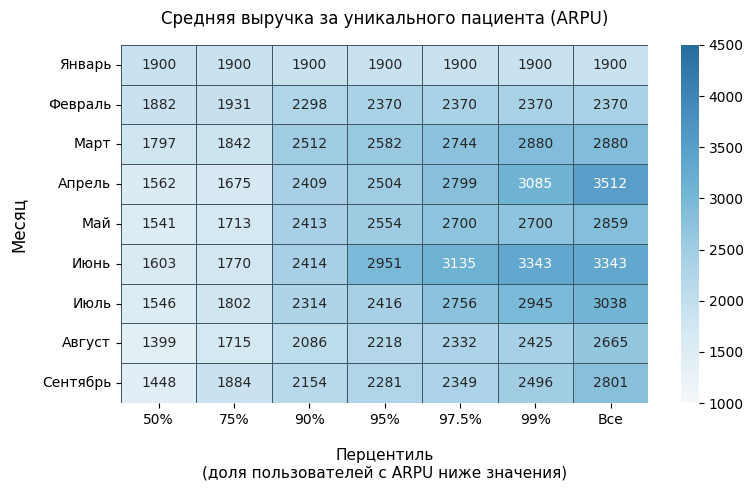

In [31]:
df_ARPU_values_montly = make_arpu_df_beautiful(pd.DataFrame(ARPU_values_montly, index=months_arpu))
df_ARPU_values_montly.index.name = 'Месяц'
df_ARPU_values_montly = df_ARPU_values_montly.rename(index=month_mapping)

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()

sns.heatmap(
    df_ARPU_values_montly,
    annot=True,
    fmt="0.0f",
    vmin=1000, vmax=4500,
    cmap=modern_turquoise_soft,
    linewidths=0.5,
    linecolor="#3e5865",
    ax=ax
)

ax.set_title('Средняя выручка за уникального пациента (ARPU)', pad=15)
ax.set_xlabel('Перцентиль\n(доля пользователей с ARPU ниже значения)', labelpad=15, fontsize=11)
ax.set_ylabel('Месяц', labelpad=10, fontsize=12)

plt.tight_layout()
plt.savefig(
    "reports/visualisation/fig10_arpu_monthly_percentile_heatmap.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

В столбце "Все" наблюдается снижение ARPU в сентябре по сравнению с июлем, несмотря на то, что вырос медианный чек и увеличилась выручка.

Это говорит о притоке новых пользователей и росте числа спроса на более дорогие услуги, но при этом снижение числа возвратов.

Иными словами, пациентов стало больше, но рост выручки обеспечен притоком низкомаржинальной аудитории.

In [32]:
f'Доля выручки от 5% наиболее платящей аудитории: {(2801-2281)/2281 * 100:.1f} %'

'Доля выручки от 5% наиболее платящей аудитории: 22.8 %'

Кроме того, 95 и 100 перцентили различаются на 520 рублей, что означает, что 5% аудитории генерирует 22,8 % выручки.

Построим кривую Лоренца, чтобы увидеть актуальное распределение ARPU между пациентами.

Август и сентябрь примерно похожи по потенциальному поведению пользователей:
- Примерно половина обоих месяцев приходится на отпуск некоторых специалистов;
- Сезонность получения справок начинается в августе и развивается в сентябре.

Рекомендуется построить кривую Лоренца для августа и сентября вместе, чтобы снизить шум при наличии малого количества записей.

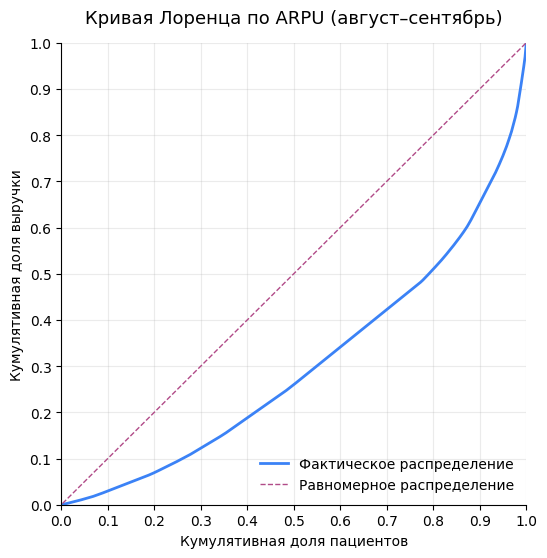

In [33]:
# === Кривая Лоренца по объединённым данным (август + сентябрь) === #

# Расчёт ARPU на пользователя за два месяца
arpu = (
    visits
    .query("month in ['2025-08', '2025-09']")
    .groupby('pat_id')['amount_rub']
    .sum()
)

# Сортировка и кумулятивные доли
sorted_arpu = np.sort(arpu)
cum_users = np.arange(1, len(arpu) + 1) / len(arpu)
cum_revenue = np.cumsum(sorted_arpu) / sorted_arpu.sum()

# Таблица для построения
lorenz = pd.DataFrame({
    'Доля пациентов': cum_users,
    'Доля выручки': cum_revenue
})

# === Визуализация === #
plt.figure(figsize=(6, 6))
sns.lineplot(
    data=lorenz,
    x='Доля пациентов',
    y='Доля выручки',
    linewidth=2.0,
    color='#3b82f6',
    label='Фактическое распределение'
)

# Линия равномерного распределения (y = x)
sns.lineplot(
    x=lorenz['Доля пациентов'],
    y=lorenz['Доля пациентов'],
    color='#b14b88ff',
    linestyle='--',
    linewidth=1,
    label='Равномерное распределение'
)

# Оформление
plt.title(
    'Кривая Лоренца по ARPU (август–сентябрь)',
    fontsize=13,
    pad=14
)

plt.xlabel('Кумулятивная доля пациентов')
plt.ylabel('Кумулятивная доля выручки')

plt.xticks(np.arange(0, 1.1, 0.1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.grid(alpha=0.25)

plt.xlim(0, 1)
plt.ylim(0, 1)

plt.legend(frameon=False, loc='lower right')
sns.despine()

plt.savefig(
    "reports/visualisation/fig11_arpu_lorenz_curve_aug_sep.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

Распределение выручки заметно неравномерное: небольшая доля пациентов формирует значительную часть дохода.

Нижние 50 % пациентов обеспечивают лишь около 25 % выручки, тогда как верхние 20 % — более 60 %.

Концентрация выручки указывает на зависимость финансового результата от ограниченного числа постоянных или высокоплатящих клиентов.

Вывод: для дальнейшего роста клиники важно повышать удержание и средний чек в массовом сегменте, чтобы снизить чувствительность бизнеса к поведению узкой группы пациентов.

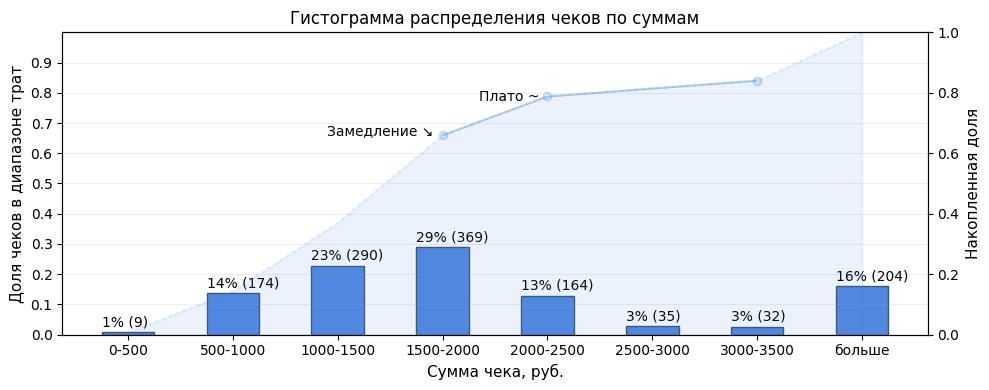

In [34]:
# Гистограмма для связки выводов о неравномерности доходов с распределением чеков
all_checks = visits.groupby(['check_id'])['amount_rub'].sum()
checks_distribution = pd.cut(all_checks,
       bins=[0, 500, 1000, 1500, 2000, 2500, 3000, 3500, float('inf')],
       labels=['0-500', '500-1000', '1000-1500', '1500-2000', '2000-2500', '2500-3000', '3000-3500', 'больше']
).value_counts().sort_index().reset_index(name='Количество чеков в категории')

n_checks = checks_distribution['Количество чеков в категории'].sum()
checks_distribution['Доля чеков в диапазоне трат'] = checks_distribution['Количество чеков в категории'].div(n_checks)
checks_distribution['Кумулятивная доля'] = checks_distribution['Доля чеков в диапазоне трат'].cumsum()

checks_distribution.rename(columns={'amount_rub': 'Сумма чека, руб.'}, inplace=True)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot()

sns.barplot(
    checks_distribution,
    x='Сумма чека, руб.',
    y='Доля чеков в диапазоне трат',
    ax=ax,
    edgecolor="#3e5865",
    width=0.5,
    color="#3b82f6"
)

ax2 = ax.twinx()

ax2.plot(
    checks_distribution['Сумма чека, руб.'],
    checks_distribution['Кумулятивная доля'],
    color="#3b82f6",
    linewidth=2,
    label='Кумулятивная доля',
    alpha=0.1,
    ls=':'
)

# заливка под кривой
ax2.fill_between(
    checks_distribution['Сумма чека, руб.'],
    checks_distribution['Кумулятивная доля'],
    color="#3b82f6",
    alpha=0.1
)

# === Подписи === #
ax2.text(
    x=3 - 1.1,
    y=checks_distribution['Кумулятивная доля'][3],
    s='Замедление ↘'
)

ax2.text(
    x=4 - 0.65,
    y=checks_distribution['Кумулятивная доля'][4] - 0.016,
    s='Плато ~'
)

dots = [
    checks_distribution['Кумулятивная доля'][3],
    checks_distribution['Кумулятивная доля'][4],
    checks_distribution['Кумулятивная доля'][6]
]

ax2.plot(
    [3, 4, 6],
    dots,
    marker='o',
    markersize=5,
    mfc='none',   
    mec='#3b82f6',     
    mew=2,       
    alpha=0.3,     
    linestyle=None,
)

# ============== #

ax2.set_ylabel("Накопленная доля", fontsize=11)
ax2.set_ylim(0, 1)

ax.set_title('Гистограмма распределения чеков по суммам')
ax.set_ylabel('Доля чеков в диапазоне трат', fontsize=11)
ax.set_xlabel('Сумма чека, руб.', fontsize=11)
ax.set_ylim(0, 1)

for i, v in enumerate(checks_distribution['Количество чеков в категории']):
    x = ax.patches[i].get_x()
    ax.text(
        x=x,
        y=v/n_checks + 0.02,
        s=f"{v/n_checks * 100:.0f}% ({v})",
    )

ax.set_yticks(np.arange(0, 1, 0.1))
ax.grid(axis='y', alpha=0.2)

plt.tight_layout()


plt.savefig(
    'reports/visualisation/fig12_check_amount_distribution_cumulative.png',
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

________
Дополнительно посмотрим, какую выручку генерируют направления врачебных приемов.

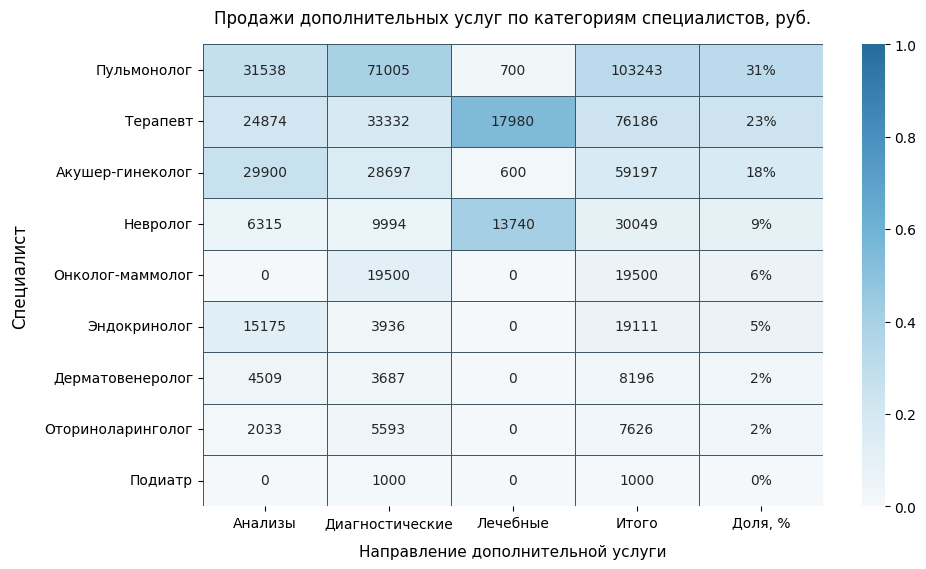

In [35]:
additinal_revenue_by_doctors = visits.query(
    "~service_category.eq('Приемы врачей') & visit_category.eq('Приемы врачей')"
).groupby(
    ['specified_visit_category', 'service_category']
)['amount_rub'].sum().unstack(fill_value=0)

additinal_revenue_by_doctors['Итого'] = additinal_revenue_by_doctors.apply(lambda row: row.sum(), axis=1)
additinal_revenue_by_doctors['Доля, %'] = additinal_revenue_by_doctors['Итого'].div(
    additinal_revenue_by_doctors['Итого'].sum()
)
additinal_revenue_by_doctors = additinal_revenue_by_doctors.sort_values('Итого', ascending=False)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot()

additinal_revenue_by_doctors_normalized = additinal_revenue_by_doctors.div(additinal_revenue_by_doctors.sum(axis=0))

annotations = additinal_revenue_by_doctors.copy()
annotations['Доля, %'] = (
    annotations['Доля, %'].mul(100).astype(int).astype(str) + '%'
)
annotations = annotations.astype(str)

sns.heatmap(
    additinal_revenue_by_doctors_normalized,
    vmin=0,
    vmax=1,
    cmap=modern_turquoise_soft,
    annot=annotations.values,
    fmt='',
    linewidths=0.5,
    linecolor="#3e5865"
)

ax.set_title('Продажи дополнительных услуг по категориям специалистов, руб.', pad=15)
ax.set_xlabel('Направление дополнительной услуги', fontsize=11, labelpad=10)
ax.set_ylabel('Специалист', fontsize=12, labelpad=12)

plt.savefig(
    'reports/visualisation/fig13_cross_sales_by_specialist_category_heatmap.png',
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

**Продажи дополнительных услуг по категориям специалистов**

**Выводы:**

Гипотеза подтверждается - рост выручки сопровождается притоком новых пациентов, при этом имеющих более низкую доходность. Это подтверждается ростом выручки при снижении ARPU.

1. **Пульмонологи (31%)** и **терапевты (23%)** обеспечивают основную долю продаж дополнительных услуг — эти направления наиболее вовлечены в кросс-продажи.  
2. **Лечебные услуги** практически не развиты у большинства специалистов, за исключением терапевтов и неврологов.  
3. У **эндокринологов, дерматовенерологов и подиатров** потенциал дополнительных услуг остаётся нераскрытым.

**Возможное решение:**
- Разработать **пакеты комплексных обследований** (например, для эндокринологов — анализы + УЗИ), чтобы увеличить средний чек и вовлечённость пациентов.


## H2: Анализ удержания пациентов

В ходе EDA анализа выручки была выдвинута гипотеза:  
- рост числа пациентов в августе–сентябре обусловлен преимущественно возвратом существующих клиентов, при этом удержание новой аудитории остаётся под вопросом.

При проверке сезонности и структуры услуг установлено:

- Возросла популярность ранее малозначимой категории “Справки”;
- Произошли кадровые изменения, вызвавшие смещение состава аудитории вслед за конкретными специалистами.

Таким образом, экстраполяция метрик удержания предыдущих месяцев приведет к искажённым выводам.  
Анализ retention в текущий период нерепрезентативен из-за:

- пика сезонности отдельных услуг;
- неустойчивости выручки по пациентам;
- высокой зависимости спроса от кадрового состава и личного бренда врачей.

Для корректной оценки удержания требуется дополнительный период стабильных наблюдений после окончания сезонного всплеска.

In [36]:
# Поиск всех дат активности пациентов
activity_df = visits.groupby(['date', 'pat_id']).apply(lambda x: True, include_groups=False).reset_index()
# Сортировка и удаление лишнего столбца
activity_df = activity_df.sort_values('date').drop(0, axis=1)
# Исправление слетевшего формата
activity_df['date'] = pd.to_datetime(activity_df['date'])

# Подсчет дней между посещениями
activity_df['diff'] = activity_df.groupby(['pat_id'])['date'].diff().dt.days

# Первый ли визит пациента (менее 3 месяцев с последнего визита)
activity_df['first_time'] = activity_df.groupby('pat_id')['diff'].transform(lambda x: x.isna() | (x > 90))

# Присвоение периода активности
# Учитывает также возврат спустя более 3 месяцев как первичный визит
activity_df['period_activity'] = activity_df.groupby('pat_id')['first_time'].cumsum()

# Когорта первого визита в клинику
activity_df['cohort'] = activity_df.groupby(['pat_id', 'period_activity'])['date'].transform(lambda s: s.min().strftime('%Y-%m'))
# Месяц текущего визита
activity_df['cur_month'] = activity_df['date'].dt.strftime('%Y-%m')


# === Retention rate === #
# Удержаные пользователи
retained_patients_per_month = (
    activity_df
    .merge(
        activity_df,
        on=['cohort'],
        how='left',
        suffixes=['_first', '_next']
    )
).query(
    "pat_id_first == pat_id_next"                       # Один и тот же пациент
).query(
    "period_activity_first == period_activity_next"     # Но в рамках одного периода активности
).query(
    "date_first < date_next"                            # В хронологическом порядке + проверка возвращений в тот же месяц
)

retained_patients_per_month['month_diff'] = (
    (retained_patients_per_month['date_next'].dt.year * 12 + retained_patients_per_month['date_next'].dt.month)
    - (retained_patients_per_month['date_first'].dt.year * 12 + retained_patients_per_month['date_first'].dt.month)
)

retained_patients_per_month = retained_patients_per_month.groupby(['cohort', 'month_diff'])['pat_id_first'].nunique()

# Общее количество пользователей
cohort_sizes = activity_df.groupby('cohort')['pat_id'].nunique()

# Retention rate table
retention_table = (
    (retained_patients_per_month / cohort_sizes)
    .unstack(fill_value=0)
).rename(index=month_mapping)

# В январе было 3 пациента, возврат 1 человека дает retention 33%, неинформативно
retention_table = retention_table.drop('Январь', axis=0)

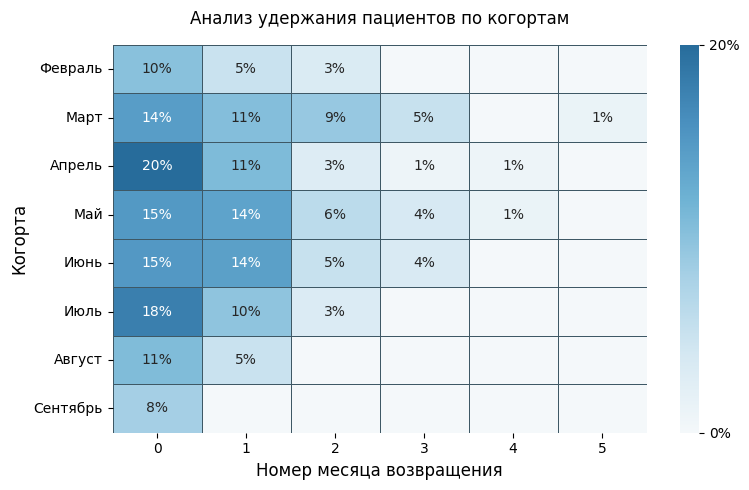

In [37]:
# === Визуализация удержания по когортам === #
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot()

# Подготовка аннотаций: проценты, без нулей
annotation_table = retention_table.mul(100).round(0).astype(int).astype(str) + '%'
annotation_table = annotation_table.replace({'0%': ''})

# Тепловая карта
hm = sns.heatmap(
    retention_table,
    annot=annotation_table,
    fmt='',
    vmin=0, vmax=0.2,
    cmap=modern_turquoise_soft,
    linewidths=0.5,
    linecolor="#3e5865",
    ax=ax,
    cbar=True
)

# Подписи и стиль
ax.set_title('Анализ удержания пациентов по когортам', pad=15)
ax.set_xlabel('Номер месяца возвращения', fontsize=12)
ax.set_ylabel('Когорта', fontsize=12)

# Настройка colorbar
cbar = hm.collections[0].colorbar
cbar.set_ticks([0, 0.2])
cbar.set_ticklabels(['0%', '20%'])
cbar.ax.tick_params(labelsize=10)

plt.tight_layout()

plt.savefig(
    "reports/visualisation/fig14_patient_retention_cohort_heatmap.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

Когорта января содержит 3 пациента: возврат одного человека дает retention 33%.

Неинформативно => убрать из анализа.

**Выводы:**

Уровень удержания пациентов остаётся низким для медицинской сферы, где решение проблем пациента обычно требует нескольких посещений.  
С марта по июнь возврат на следующий месяц составлял **10–14%**, однако в августе показатель снизился до **5%**.  
Частично это может быть связано с ростом доли пациентов, обращающихся за справками (услуги разового характера).  

В целом, текущий анализ отражает **падение регулярных визитов** и отсутствие устойчивого ядра постоянных пациентов.  
К оценке удержания целесообразно вернуться после проведения **промо-акций и программ лояльности**, направленных на повышение возвратности клиентов.


## H4: Анализ оттока вторичных пациентов

**Гипотеза**: среди вторичных пациентов низкий отток, большая доля из вторичных - сформированная база в апреле-июне.

Проверка частично перекрывается гипотезой H2 (анализ удержания).

Результаты анализа **опровергают гипотезу**: большинство визитов вторичных пациентов ограничивается 1–2 месяцами (10-20% возвращаются),  
на 3–4 месяце количество повторных визитов сокращается примерно вдвое (3-9%),  
а затем практически полностью прекращается.  

Таким образом, клиника пока не формирует устойчивое ядро постоянных клиентов, а возвратные визиты носят краткосрочный характер.

## H3: Распределение первичных и вторичных записей по источникам записи

**Ключевая идея:** повторные пациенты через прямую запись возвращаются не чаще, чем через агрегаторы.

После анализа удержания пациентов и динамики повторных визитов важно понять, как ведут себя пациенты разных каналов привлечения.  
В этом разделе рассматривается распределение **первичных и вторичных обращений** по источникам записи — через **агрегатор “ПроДокторов”** и при **самостоятельной записи**.  

Цель анализа — определить, отличается ли способ записи между первичными и повторными визитами.  
Для этого применяется **хи-квадрат тест независимости**, позволяющий выявить статистически значимую связь между типом пациента и источником записи.


In [38]:
channels_modified = channels.copy()

# Каналы: ПроДокторов, Медфлекс, МедТочка, НаПоправку - агрегаторы
channels_modified['self_registration'] = pd.Series(dtype='bool')

# Категоризация источников по способу записи
mask = channels_modified['channel'].isin(['Не указан', '2GIS', 'Яндекс Карты'])
channels_modified.loc[mask, 'self_registration'] = True
channels_modified['self_registration'] = channels_modified['self_registration'].astype('boolean').fillna(False)

# Таблица для проверки статистической значимости различий между источниками записи
visit_source_table = pd.crosstab(
    channels_modified['visit_cat'],
    channels_modified['self_registration']
)

visit_source_table

self_registration,False,True
visit_cat,,
Вторичный,116,296
Первичный,485,664


In [39]:
chi2, p, dof, expected = chi2_contingency(visit_source_table)
print(f"Вероятность получить такие наблюдения или более экстремальные: {p*100:.5f} %")

if p <= 0.025:
    print("Нулевая гипотеза отвергается: повторная запись на прием значимо связана с источником записи.")
else:
    print("Нет оснований отвергнуть нулевую гипотезу: вторичные посещения между способами записи отличаются статистически незначимо.")

Вероятность получить такие наблюдения или более экстремальные: 0.00007 %
Нулевая гипотеза отвергается: повторная запись на прием значимо связана с источником записи.


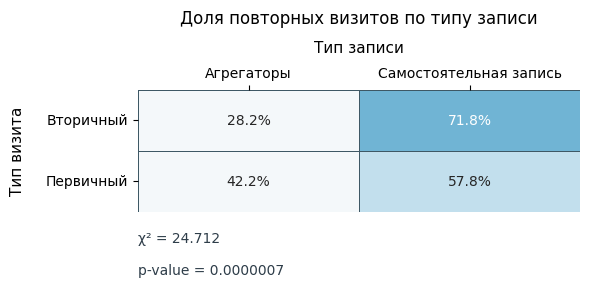

In [40]:
# === Нормализованная таблица (доли по строкам) ===
visit_source_table_normalized = pd.crosstab(
    channels_modified['visit_cat'],
    channels_modified['self_registration'],
    normalize='index'
)

# === Визуализация ===
fig, ax = plt.subplots(figsize=(6, 3.5))

# Формат аннотаций
annot_table = (visit_source_table_normalized * 100).round(1).astype(str) + '%'

sns.heatmap(
    visit_source_table_normalized,
    annot=annot_table,
    fmt='',
    cmap=modern_turquoise_soft,
    cbar=False,
    linewidths=0.5,
    linecolor="#3e5865",
    vmin=0.45, vmax=0.9,
    ax=ax
)

# === Заголовки ===
ax.set_title('Доля повторных визитов по типу записи', fontsize=12, pad=12)
ax.set_xlabel('Тип записи', fontsize=11, labelpad=10)
ax.set_ylabel('Тип визита', fontsize=11, labelpad=15, rotation=90)

ax.set_xticklabels(['Агрегаторы', 'Самостоятельная запись'])
ax.set_yticklabels(visit_source_table_normalized.index, rotation=0)

# === Перемещение xlabel наверх ===
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()

# === Подпись p-value под графиком ===
ax.text(
    0, -0.35,
    f"χ² = {chi2:.3f}\n\np-value = {p:.7f}",
    ha='left', va='center',
    fontsize=10, color='#2e3d49',
    transform=ax.transAxes
)

plt.tight_layout()

plt.savefig(
    "reports/visualisation/fig15_repeat_visits_by_booking_type.png",
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

Дополнительно можно проверить зависимость доли вторичных пациентов от их канала записи пермутационным тестом.

В отличии от хи-квадрат теста независимости, он не делает предположения о независимости исходных наблюдений.

In [41]:
df = channels_modified.copy()

# Создание групп по типу регистрации
group1 = df.loc[df['self_registration'] == True, 'visit_cat'].copy()
group2 = df.loc[df['self_registration'] == False, 'visit_cat'].copy()

# Присваивание целевой категории булевого типа
mapper = {'Первичный': 0, 'Вторичный': 1}
group1, group2 = group1.replace(mapper), group2.replace(mapper)

# Разница в долях вторичек между самостотельной регистраций и через агрегатора
diff_observed = group1.mean() - group2.mean()

# Скидываем все в одну кучу, чтобы потерять тег и перемешать
arr_combined = np.concatenate([group1, group2])
group_len = len(group1)

n_permutations = 10_000         # Количество пермутаций

# Массив результатов
diffs_obtained = np.empty(n_permutations)

for i in range(n_permutations):
    # Пермутация
    np.random.shuffle(arr_combined)
    # Деление по исходным размерам
    a = arr_combined[group_len:]
    b = arr_combined[:group_len]
    # Запись разницы целевой метрики
    diffs_obtained[i] = np.mean(a) - np.mean(b)

# Подсчет доли случаев, когда отклонения превышали исходное наблюдение
p_value = (
    (np.mean((np.abs(diffs_obtained) >= np.abs(diff_observed))) + 1) 
    / (n_permutations + 1)
)

print(f"p_value пермутационного теста: {p_value:.4f}")

C:\Users\pavsabiroff\AppData\Local\Temp\ipykernel_2936\2131283856.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  group1, group2 = group1.replace(mapper), group2.replace(mapper)


p_value пермутационного теста: 0.0001


Доверительные интервалы для долей в категориальных данных можно найти методом Клоппера-Пирсона:

In [42]:
def clopper_pearson(k, n, alpha=0.05):
    if k == 0:
        lower = 0.0
    else:
        lower = beta.ppf(alpha / 2, k, n - k + 1)

    if k == n:
        upper = 1.0
    else:
        upper = beta.ppf(1 - alpha / 2, k + 1, n - k)

    return lower, upper

In [43]:
# Самостоятельная запись
k = visit_source_table.loc['Вторичный', True]
n = k + visit_source_table.loc['Вторичный', False]

l_bound, u_bound = clopper_pearson(k, n)
print(f"Границы CI 95%:\n{l_bound * 100:.1f}%, {u_bound * 100:.1f}%")

Границы CI 95%:
67.2%, 76.1%


In [44]:
# Агрегаторная запись
k = visit_source_table.loc['Вторичный', False]
n = k + visit_source_table.loc['Вторичный', True]

l_bound, u_bound = clopper_pearson(k, n)
print(f"Границы CI 95%:\n{l_bound * 100:.1f}%, {u_bound * 100:.1f}%")

Границы CI 95%:
23.9%, 32.8%


Неконсистентность информации может привести к смещенным выводам. Например, в таблицах visits и channels есть разное количество записей на одного пациента.

При этом каналы записи могут быть разными.

In [45]:
# Запись пациента P000506 в таблице кассовых операций
visits[visits['pat_id']=='P000506'][['date', 'pat_id', 'visit_category', 'specified_visit_category']]

,date,pat_id,visit_category,specified_visit_category
0,2025-09-29,P000506,Диагностические,ЭКГ


In [46]:
# Запись пациента P000506 в таблице записей
channels_modified[channels_modified['pat_id']=='P000506'][['visit_date', 'channel', 'visit_cat', 'self_registration']]

,visit_date,channel,visit_cat,self_registration
824,2025-09-29,МедТочка,Первичный,False
825,2025-09-29,Не указан,Первичный,True


В данном случае пациент записался на прием с двух разных источников, но оплатил все единым чеком.

Для повышения информативности аналитики рекомендуется:
- ввести систему учета записей, которая позволит связать подробную информацию по проданным услугам и каналам привлечения пациентов:

Это также позволит отследить:
- расходы на привлечение пациента
- рассчитать LTV/CAC
- устранить композиционное смещение по категориям визитов на уровне сбора информации

Стоит проверить, не генерируют ли агрегаторы больше выручки, несмотря на меньший объем привлечения.

In [47]:
revenue_per_source_registration = (
    channels_modified
    .groupby('self_registration')['services_sum_rub']
    .sum()
    .reset_index(name='revenue')
    .assign(revenue_share=lambda s: s['revenue'] / s['revenue'].sum())
)

patients_per_source_registration = (
    channels_modified
    .groupby('self_registration')['pat_id']
    .count()
    .reset_index(name='cnt')
    .assign(acquisition_share=lambda s: s['cnt'] / s['cnt'].sum())
)

final_common_stat = patients_per_source_registration.merge(
    revenue_per_source_registration,
    on='self_registration',
    how='left'
)[['self_registration', 'revenue', 'revenue_share', 'cnt', 'acquisition_share']].rename(
    columns={
        'self_registration': 'Источник',
        'revenue': 'Выручка',
        'revenue_share': 'Доля выручки',
        'cnt': 'Записей',
        'acquisition_share': 'Доля записей'
    }
)

final_common_stat.insert(value=['Агрегаторы', 'Самостоятельно'], column='Источник записи', loc=0)
final_common_stat = final_common_stat.drop(axis=1, labels='Источник')
final_common_stat

,Источник записи,Выручка,Доля выручки,Записей,Доля записей
0,Агрегаторы,1036351,0.374949,601,0.38501
1,Самостоятельно,1727624,0.625051,960,0.61499


Источники записи генерируют выручку пропорционально количеству привлеченных пациентов.

Из этого следует, что агрегаторы не приводят большее маржинальную аудиторию, но приводят нелояльную.

Поэтому агрегаторы можно использовать как канал для первичного знакомства клиента с клиникой, впоследствии работая над информационной обеспеченностью пациента и конверсии его во вторичный поток.

_____________
Дополнительно проверим по каким услугам чаще всего нет возврата пациента.

In [48]:
combined_channels_visits = visits.merge(
    channels_modified,
    left_on=['pat_id', 'date'],
    right_on=['pat_id', 'visit_date'],
    suffixes=['_v', '_c']
)[['pat_id', 'date', 'visit_cat', 'self_registration', 'visit_category', 'specified_visit_category', "certificate_obtaining"]]

combined_channels_visits.head()

,pat_id,date,visit_cat,self_registration,visit_category,specified_visit_category,certificate_obtaining
0,P000506,2025-09-29,Первичный,False,Диагностические,ЭКГ,False
1,P000506,2025-09-29,Первичный,True,Диагностические,ЭКГ,False
2,P000560,2025-09-29,Первичный,True,Справки,Справки,True
3,P000183,2025-09-29,Первичный,True,Справки,Справки,True
4,P000659,2025-09-29,Первичный,False,Приемы врачей,Дерматовенеролог,False


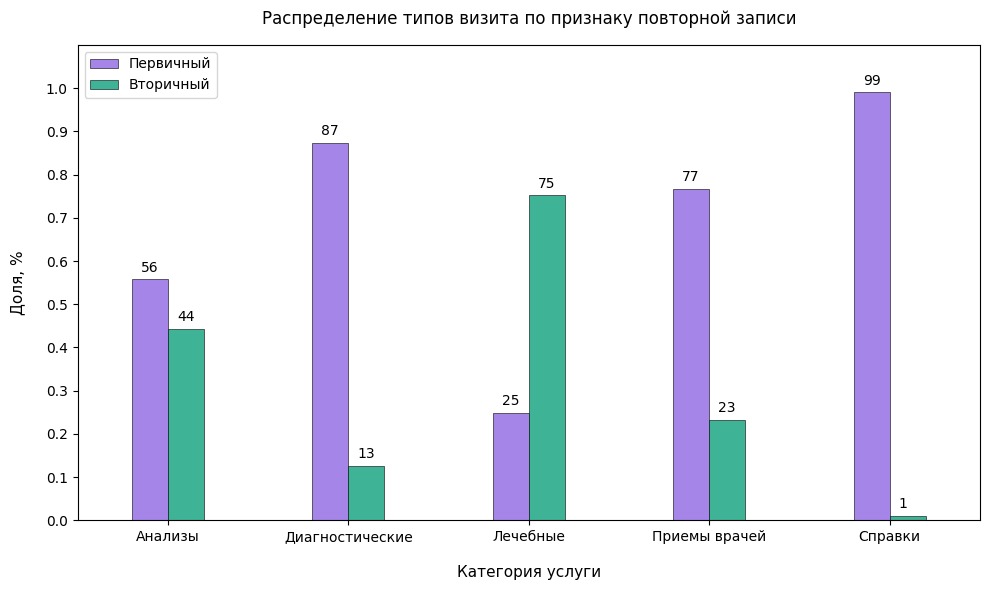

In [49]:
# Распределение по общим категориям
common_dist = combined_channels_visits.groupby(['visit_category', 'visit_cat'])['visit_cat'].count().reset_index(name='Количество')
common_dist['Количество'] = common_dist.groupby('visit_category')['Количество'].transform(lambda s: s / s.sum())
common_dist = common_dist.rename(columns={'Количество': 'Доля'})
common_dist = common_dist.sort_values(['visit_cat', 'visit_category'], ascending=[False, True])

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot()

palette = {
    'Первичный': '#A074F8',  # фиолетовый
    'Вторичный': '#2AC7A0'   # бирюзовый
}

sns.barplot(
    common_dist,
    x='visit_category',
    y='Доля',
    hue='visit_cat',
    hue_order=['Первичный', 'Вторичный'],
    ax=ax,
    palette=palette, edgecolor='black', linewidth=0.4,
    width=0.4
)

ax.set_ylim(0, 1.1)
ax.set_yticks(np.arange(0, 1.1, 0.1))
# ax.grid(True, axis='y', alpha=0.07, color='black', )
ax.set_title('Распределение типов визита по признаку повторной записи', pad=15)
ax.set_xlabel('Категория услуги', fontsize=11, labelpad=15)
ax.set_ylabel('Доля, %', fontsize=11, labelpad=15)
ax.legend()

annot_series = common_dist.sort_values(['visit_cat', 'visit_category'], ascending=[False, True])['Доля']

for i, v in enumerate(annot_series):
    x = ax.patches[i].get_x()
    width = ax.patches[i].get_width()
    y = ax.patches[i].get_height()

    ax.text(
        x = x + width/2 - 0.05,
        y = y + 0.018,
        s = f"{v*100:.0f}"
    )

plt.tight_layout()

plt.savefig(
    'reports/visualisation/fig16_visit_type_by_service_category.png',
    dpi=300,
    bbox_inches="tight",
    transparent=False
)

plt.show()

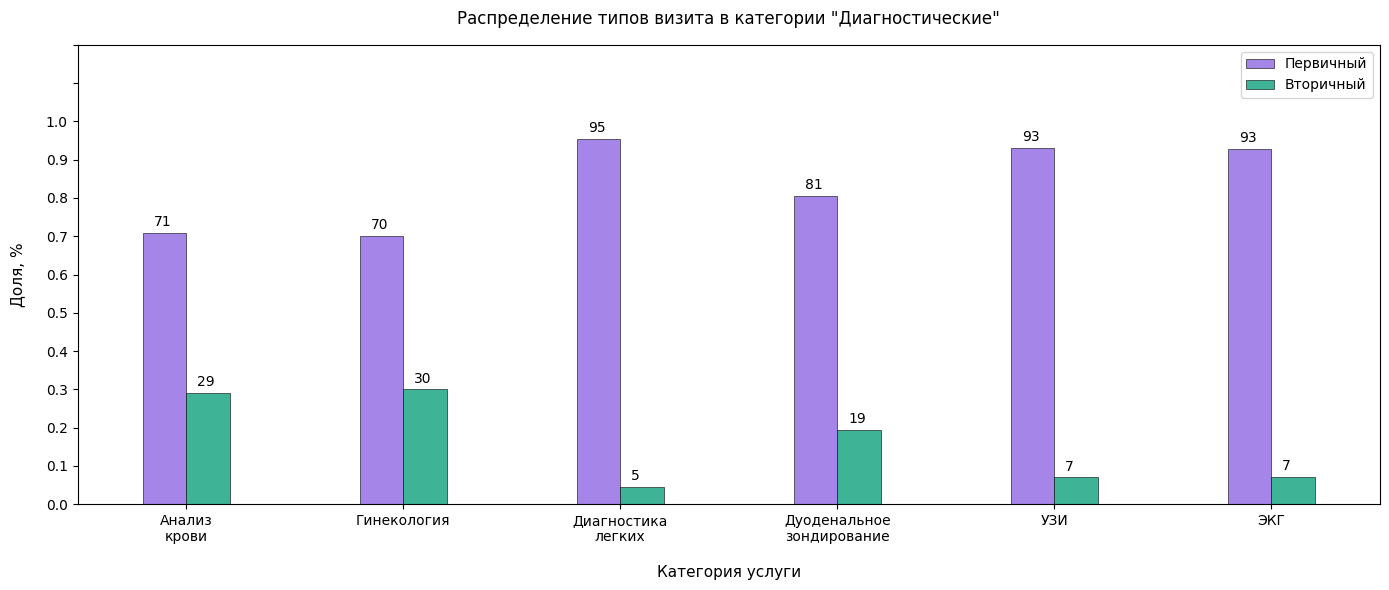

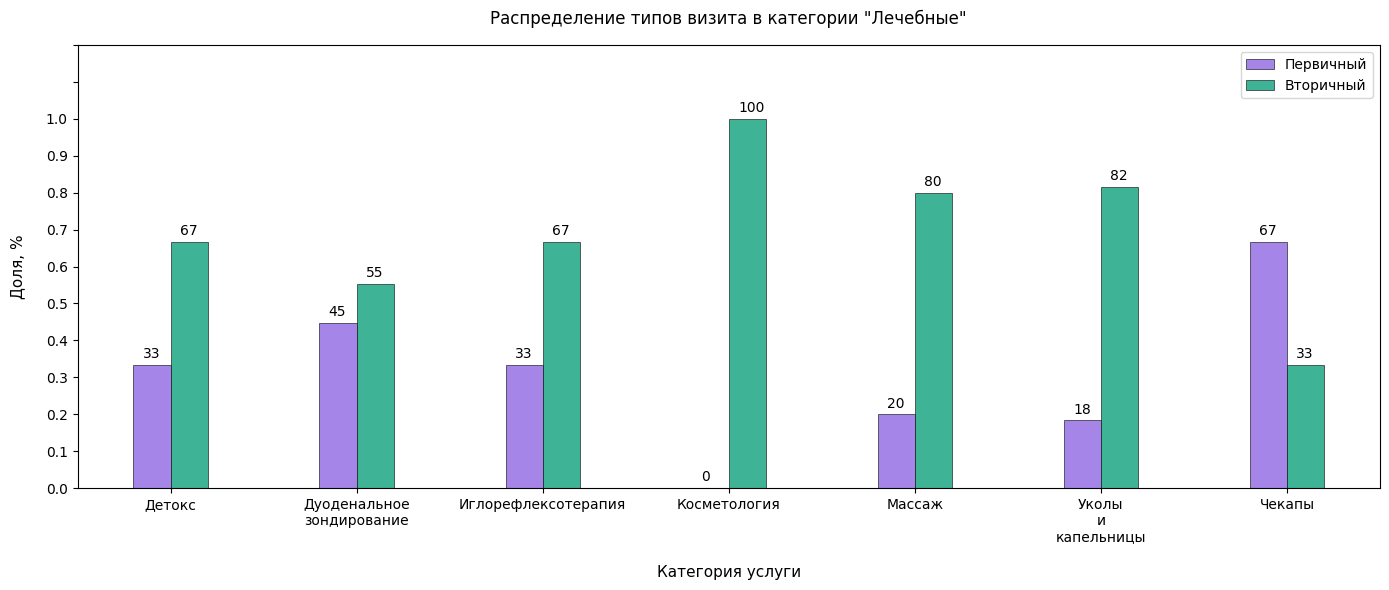

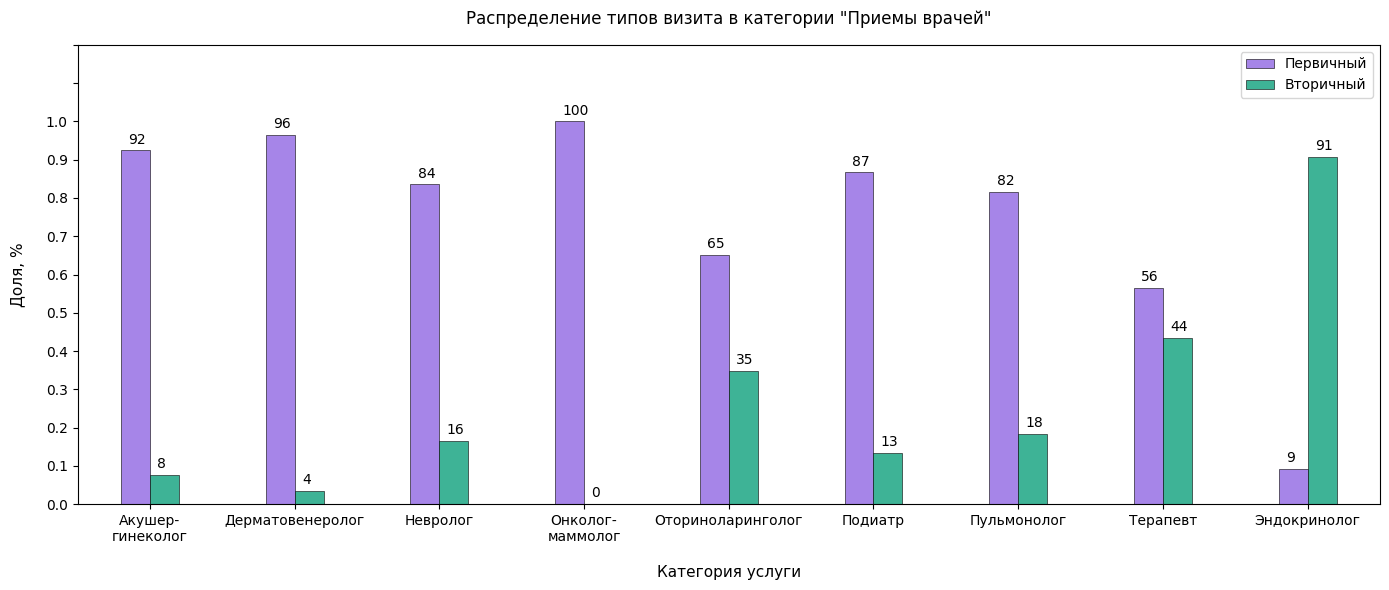

In [50]:
# Распределение по подробным категориям
spec_distr = combined_channels_visits.groupby(['visit_category', 'specified_visit_category', 'visit_cat'])['visit_cat'].count().reset_index(name='cnt')
spec_distr['Доля'] = spec_distr.groupby(['visit_category', 'specified_visit_category'])['cnt'].transform(lambda s: s / s.sum())

for cat_i, cat in enumerate(['Диагностические', 'Лечебные', 'Приемы врачей']):
    data_temp = spec_distr[spec_distr['visit_category'] == cat][['visit_cat', 'specified_visit_category', 'cnt', 'Доля']]
    data_temp = data_temp.sort_values(['visit_cat', 'specified_visit_category'], ascending=[False, True])
    data = data_temp.pivot_table(index='specified_visit_category', columns='visit_cat', values='Доля', fill_value=0).reset_index().melt(id_vars='specified_visit_category', value_name='Доля')
    data = data.map(lambda x: x.replace(' ', '\n') if isinstance(x, str) else x)
    data = data.map(lambda x: x.replace('-', '-\n') if isinstance(x, str) else x)
    
    if len(data) >= 10:
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot()
    else:
        fig = plt.figure(figsize=(10, 6))
        ax = fig.add_subplot()

    palette = {
        'Первичный': '#A074F8',  # фиолетовый
        'Вторичный': '#2AC7A0'   # бирюзовый
    }

    sns.barplot(
        data,
        x='specified_visit_category',
        y='Доля',
        hue='visit_cat',
        hue_order=['Первичный', 'Вторичный'],
        ax=ax,
        palette=palette, edgecolor='black', linewidth=0.4,
        width=0.4
    )

    ax.set_ylim(0, 1.0)
    y_ticks = np.arange(0, 1.3, 0.1).round(1).astype(str)
    y_ticks[-2:] = ""
    ax.set_yticks(np.arange(0, 1.3, 0.1))
    ax.set_yticklabels(y_ticks)
    
    # ax.grid(True, axis='y', alpha=0.07, color='black', )
    ax.set_title(f'Распределение типов визита в категории "{cat}"', pad=15)
    ax.set_xlabel('Категория услуги', fontsize=11, labelpad=15)
    ax.set_ylabel('Доля, %', fontsize=11, labelpad=15)
    ax.legend()

    # Аннотации к процентам
    annot_percents = data.sort_values(['visit_cat', 'specified_visit_category'], ascending=[False, True])['Доля']

    for i, v in enumerate(annot_percents):
        x = ax.patches[i].get_x()
        width = ax.patches[i].get_width()
        y = ax.patches[i].get_height()

        ax.text(
            x = x + width/2 - 0.05,
            y = y + 0.018,
            s = f"{v*100:.0f}"
        )

    plt.tight_layout()

    plt.savefig(
        f'reports/visualisation/fig{17+cat_i}_visit_type_{cat.split(' ')[0]}_subcategory_distribution.png',
        dpi=300,
        bbox_inches="tight",
        transparent=False
    )

____________
**Выводы по структуре первичных и повторных визитов**

Результаты двух независимых статистических тестов — χ²-теста независимости и пермутационного теста — показали, что тип записи на приём **статистически значимо связан** с вероятностью повторного визита.

При χ²(1)=24.7, p≈7×10⁻⁷ и p≈1×10⁻⁴ в непараметрическом тесте вероятность случайного возникновения столь сильной разницы **крайне мала**.

Таким образом, пациенты, **записывающиеся самостоятельно**, возвращаются повторно значительно чаще (71.8% против 28.2% у пациентов, пришедших через агрегаторы).  
Это указывает на то, что **самостоятельная запись коррелирует с более высокой вовлечённостью и удержанием пациентов**.

По результатам точного метода **Клоппера–Пирсона** (α=0.05) доверительный интервал для вероятности повторного визита при самостоятельной записи составляет:
- самостоятельной записи:
    - нижняя граница: **67.2 %**
    - верхняя граница: **76.1 %**
- агрегаторной записи:
    - нижняя граница: **23,9 %**
    - верхняя граница: **32,8 %**
____________
В ряде случаев пациенты записываются на приём из разных источников, но оплачивают все услуги единым чеком. Это затрудняет корректную интерпретацию первичных и повторных визитов, поскольку не позволяет отследить реальный источник привлечения и повторного обращения.  

Для повышения информативности аналитики необходимо внедрить систему учёта записей, которая позволит связывать данные по проданным услугам с каналами привлечения пациентов. Это даст возможность:
- отслеживать расходы на привлечение пациента;
- рассчитать LTV и CAC;
- устранить композиционное смещение по категориям визитов на уровне сбора данных.

____________

Анализ распределения типов визита показал, что структура первичных и вторичных обращений существенно различается между категориями услуг:

* **Справки** и **диагностические услуги** почти полностью состоят из первичных визитов — пациенты обращаются по единичной потребности, без повторных записей.  
* **Лечебные услуги** напротив, формируют значительную долю вторичных визитов (до 70–100 %), что соответствует типичному паттерну возвращающихся пациентов на курсы процедур.  
* **Приёмы врачей** преимущественно первичные, но по ряду направлений (например, эндокринология, оториноларингология) доля повторных обращений достигает 30–40 %. Это говорит о потенциале развития программ наблюдения и комплексных услуг.  
* **Анализы** занимают промежуточную позицию — здесь присутствует умеренный баланс первичных и вторичных обращений, что указывает на возможность повторных визитов в рамках диагностического цикла.

Таким образом:
- лечебные категории обеспечивают **основной вклад в удержание** пациентов;
- диагностические и справочные услуги служат **входной точкой (фронт-воронкой)** для новых клиентов;
- высокая первичность в анализах и приёмах врачей подчёркивает потенциал для **создания повторных предложений** — контрольных обследований, плановых визитов и пакетов услуг.




**Выводы:**
- Вероятность повторного визита в клинику статистически зависит от типа записи на приём (самостоятельно или через агрегаторы).  
- Пациенты, пришедшие по агрегаторам, демонстрируют существенно более низкий уровень возврата.  
- Следует сделать акцент на повышении удержания пациентов, в частности — на вовлечении тех, кто впервые пришёл через агрегаторы, в прямые каналы коммуникации и повторные визиты.
